# Electoral College Data Analysis

The purpose of this project is to analyze the how the electoral college votes were distributed after the 2010 census, look at how the redistribution of population (by estimate) has shifted over time until today, and what that means for the voter per electoral college vote in each state. I will also analyze how we expect the electoral college to be redistributed after the 2020 census, given census bureau predictions.

An analysis will also be performed on the percentage likelihood of each state giving its electoral college votes to a particular party and their respective nominees, based purely on historical data. The aim is to demonstrate which states have the greatest power per vote, given both their current electoral votes allotted and the likelihood of that state assigning thier votes to either candidate.

### Vizualizations
- viz of state pops over time (5 lowest, 5 highest)
- animation of voter potency (voters / electoral vote)
- electoral votes w/ new census - forecasted
- electoral votes w/ 2019 numbers
- voter potency w/ new census
- guaranteed (statistically) electoral votes for each party
- swing states and leanings and votes

## Import

In [43]:
#import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import requests
import json
import copy

from fbprophet import Prophet

import sqlite3
%matplotlib inline

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [2]:
def reciprocal_geometric_mean(next_house_seat):
    """
    Calculates the reciprocal geometric mean for the next house seat a state could potentially receive
    """
    return 1 / np.sqrt(next_house_seat*(next_house_seat-1))

In [3]:
def priority_value(state_pop, next_house_seat):
    """
    Calculates the priority value a state has for receiving another house seat.
    The highest priority value state gets the next house seat available.
    """
    return int(round(state_pop * reciprocal_geometric_mean(next_house_seat), 0))

In [4]:
def distribute_house_seats(state_dict):
    """
    Iterates through all available house seats after initial 50 are distributed (one to each state)
    to determine who should get each next house seat according to priority value
    """
        
    distributed_dict = copy.deepcopy(state_dict)
    #iterates over all available house seats, range chosen for actual house seat being evaluated
    #whichever state is highest, add one house seat and recalculate the priority value
    for i in range(51, 436):
        next_state = assign_next_seat(distributed_dict)
        distributed_dict[next_state]['House_seats'] += 1
        distributed_dict[next_state]['Priority_value'] = priority_value(distributed_dict[next_state]['Population'], 
                                                                        distributed_dict[next_state]['House_seats']+1)
    
    #return the dictionary with properly distributed house seats    
    return distributed_dict

In [5]:
def assign_next_seat(distributed_dict):
    """
    Assigns the next house seat available according to current priority values for each state
    Returns a list with the first value as the state who should get the next seat
    """
    top_value = ["",0]
    
    #iterate through the dictionary keys and keep the state and value for whoever has the 
    #highest priority value
    for state in distributed_dict.keys():
        if distributed_dict[state]['Priority_value'] > top_value[1]:
            top_value = [state, distributed_dict[state]['Priority_value']]  
    
    #return just the state with the top priority value
    return top_value[0]

In [23]:
def sql_response_to_csv(c, cols, doc_name):
    rows_list = []
    response = c.fetchall()
    
    query_col_count = len(response[0])
    passed_col_count = len(cols)
    if query_col_count != passed_col_count:
        return "Did not convert to CSV. Number of columns in SQL query ({}) does not match number of \
                passed columns ({})".format(query_col_count, passed_col_count)

    for item in response:
        temp_dict = {}
        for i in range(len(cols)):
            temp_dict.update({cols[i]: item[i]})
        rows_list.append(temp_dict)

    df = pd.DataFrame(rows_list).drop('id', axis=1)
    df.to_csv(doc_name, index=False)
    
    return df

## Pull Data for Analysis

We start our analysis in 1980 as that year was the one of the biggest landslide victories (489 electoral votes for Reagan, only 49 for Jimmy Carter) in recent history (https://www.270towin.com/historical-presidential-elections/timeline/). It therefore serves as a decent starting point for how states have adjusted in their voting preferences over time. It also serves as a pivotal point in the structure of the political parties and how the populace aligns themselves politically. The Republican party, with that election, adopted Reaganomics, which is still largely followed by that party in today's climate.

In [7]:
conn = sqlite3.connect('census_pop_data.db')
c = conn.cursor()

In [8]:
c.execute('SELECT * \
           FROM election_results \
           WHERE year >= 1980 AND state NOT IN ("Puerto Rico") \
           ORDER BY year, state')

columns=['id', 'year', 'state', 'dem_cand', 'dem_vote', 'rep_cand', 'rep_vote', 'tot_state_vote']

election_results_df = sql_response_to_csv(c, columns, 'cleaned_election_results_1980.csv')
    
display(election_results_df.head())
display(election_results_df.info())

,year,state,dem_cand,dem_vote,rep_cand,rep_vote,tot_state_vote
0,1980,Alaska,"Carter, Jimmy",41842,"Reagan, Ronald",86112,158445
1,1980,Arizona,"Carter, Jimmy",246843,"Reagan, Ronald",529688,873945
2,1980,Arkansas,"Carter, Jimmy",398041,"Reagan, Ronald",403164,837582
3,1980,California,"Carter, Jimmy",3082943,"Reagan, Ronald",4522994,8582938
4,1980,Colorado,"Carter, Jimmy",368009,"Reagan, Ronald",652264,1184450


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509 entries, 0 to 508
Data columns (total 7 columns):
year              509 non-null int64
state             509 non-null object
dem_cand          509 non-null object
dem_vote          509 non-null int64
rep_cand          509 non-null object
rep_vote          509 non-null int64
tot_state_vote    509 non-null int64
dtypes: int64(4), object(3)
memory usage: 28.0+ KB


None

In [25]:
c.execute('SELECT * \
           FROM population \
           WHERE state NOT IN ("Puerto Rico") \
           ORDER BY state, year')

columns=['id', 'year', 'state', 'pop', 'overseas_pop']

population_df = sql_response_to_csv(c, columns, 'cleaned_population_2010.csv')
    
display(population_df.head())
display(population_df.info())

,year,state,pop,overseas_pop
0,2010,Alabama,4779736,23246
1,2011,Alabama,4799069,23340
2,2012,Alabama,4815588,23420
3,2013,Alabama,4830081,23490
4,2014,Alabama,4841799,23547


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 510 entries, 0 to 509
Data columns (total 4 columns):
year            510 non-null int64
state           510 non-null object
pop             510 non-null int64
overseas_pop    510 non-null int64
dtypes: int64(3), object(1)
memory usage: 16.1+ KB


None

In [10]:
c.execute('SELECT * \
           FROM npvic_status \
           WHERE state NOT IN ("Puerto Rico") \
           ORDER BY state')

columns=['id', 'state', 'status']

npvic_df = sql_response_to_csv(c, columns, 'cleaned_npvic_status.csv')
    
display(npvic_df.head())
display(npvic_df.info())

,state,status
0,Alaska,0.0
1,Arizona,0.5
2,Arkansas,0.5
3,California,1.0
4,Colorado,1.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 2 columns):
state     50 non-null object
status    50 non-null float64
dtypes: float64(1), object(1)
memory usage: 928.0+ bytes


None

In [119]:
pop_pred_2020 = {}

In [120]:
state= "Alaska"

temp_df = population_df[population_df['state'] == state].copy()
temp_df['year'] = pd.to_datetime(temp_df['year'], format="%Y")
temp_df['total_pop'] = temp_df['pop'] + temp_df['overseas_pop']
temp_df.drop(['state', 'pop', 'overseas_pop'], axis=1, inplace=True)

temp_df.set_index('year', inplace=True)
temp_df = temp_df.resample('BMS').asfreq()
temp_df.interpolate(inplace=True)
temp_df = temp_df.astype({'total_pop': 'int64'})
temp_df.reset_index(inplace=True)
temp_df.rename({'year': 'ds', 'total_pop': 'y'}, axis =1, inplace=True)

model=Prophet()
model.fit(temp_df)
future = model.make_future_dataframe(periods=12, freq='BMS')
forecast = model.predict(future)

pred_2020 = int(forecast[forecast['ds'] == '2020'].yhat.values[0])
pop_pred_2020.update({state: pred_2020})

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [121]:
pop_pred_2020

{'Alaska': 739841}

In [100]:
model=Prophet()
model.fit(temp_df)
future = model.make_future_dataframe(periods=12, freq='BMS')
forecast = model.predict(future)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


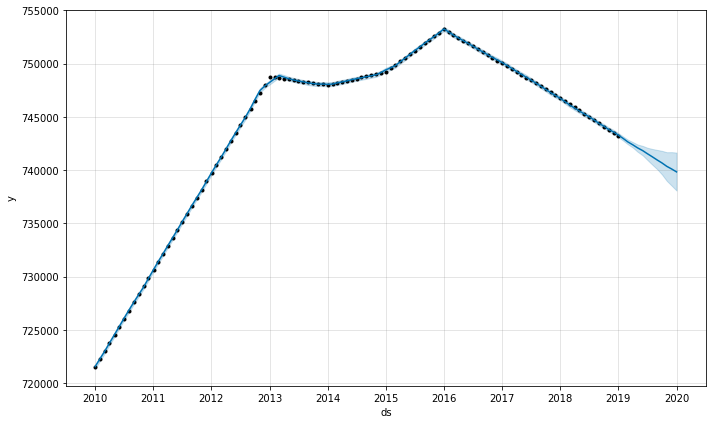

In [102]:
forecast = model.predict(future)
fig = model.plot(forecast)

In [118]:
forecast[forecast['ds'] == '2020'].yhat.values[0]

739841.1131962094

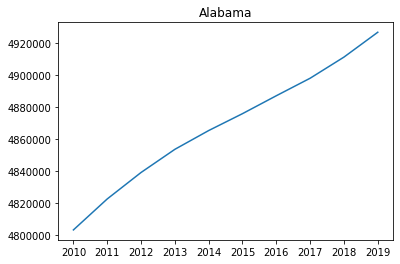

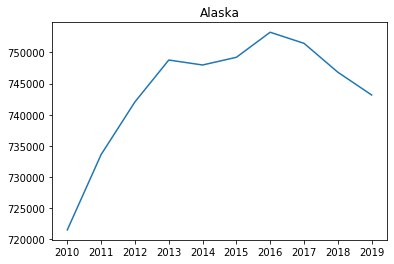

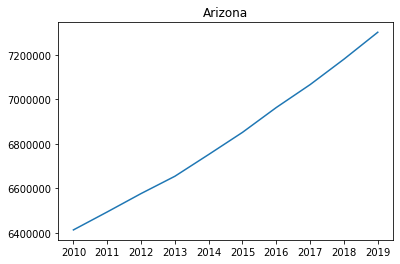

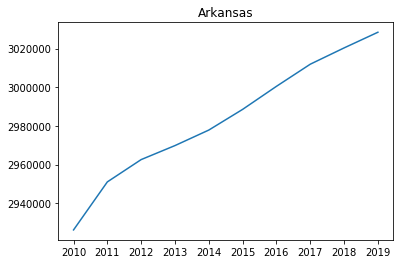

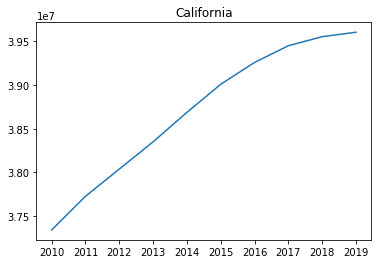

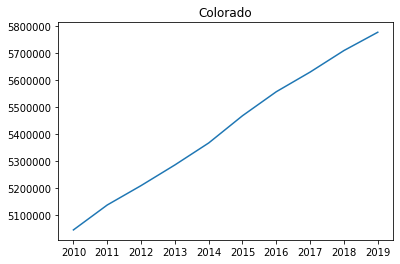

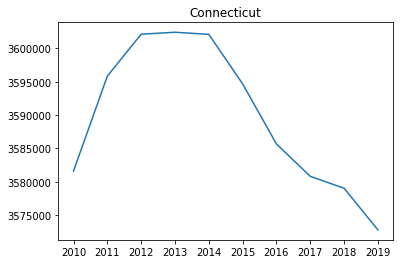

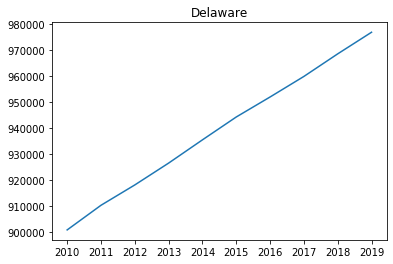

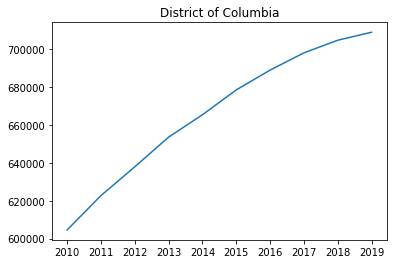

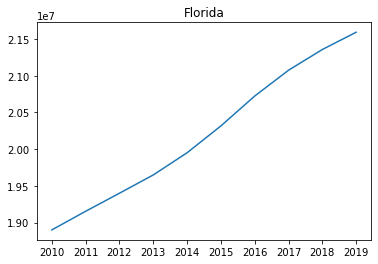

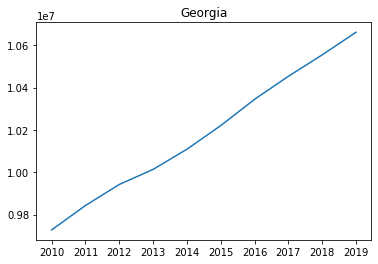

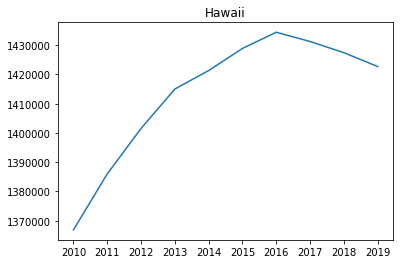

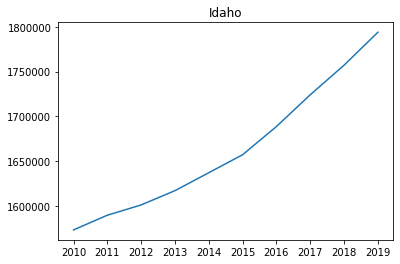

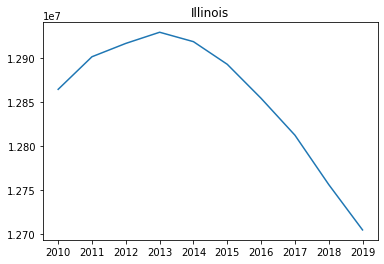

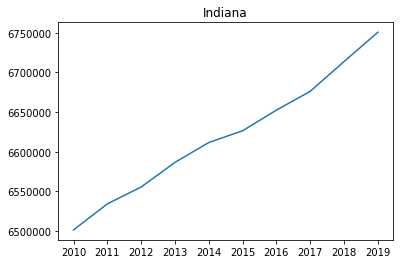

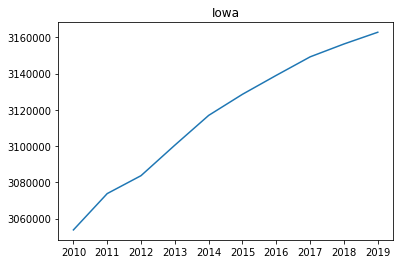

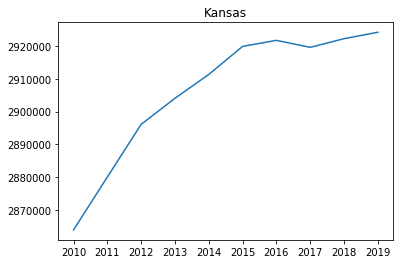

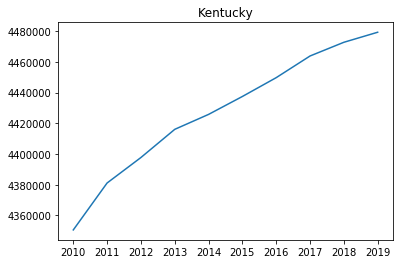

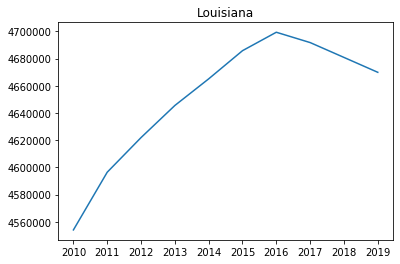

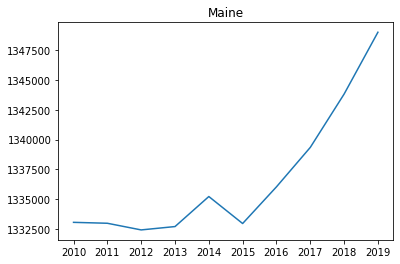

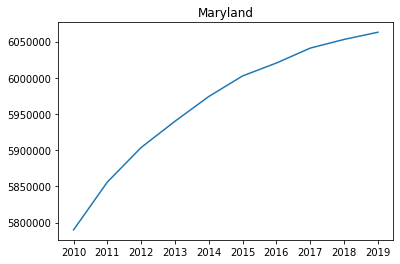

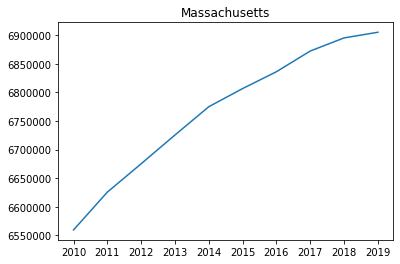

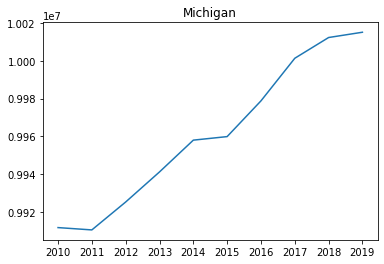

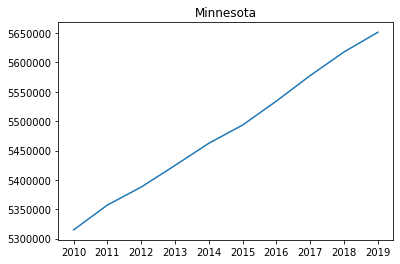

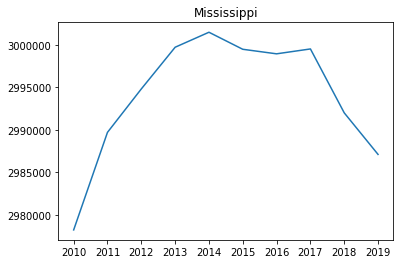

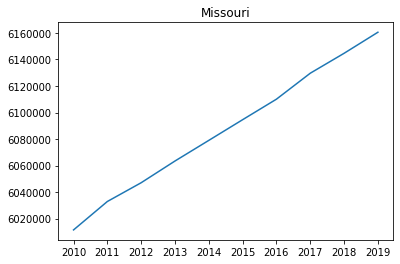

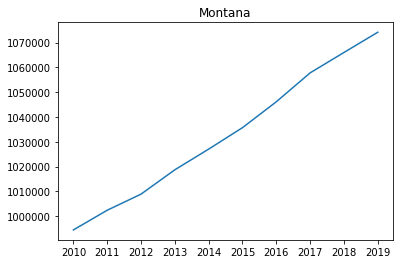

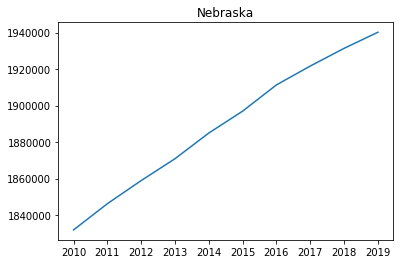

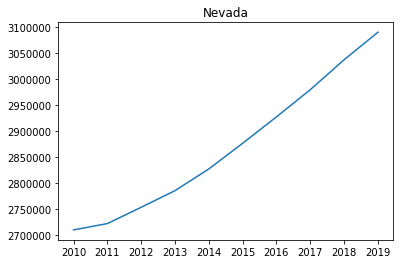

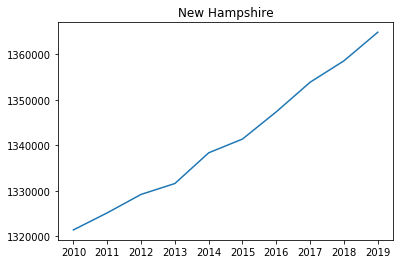

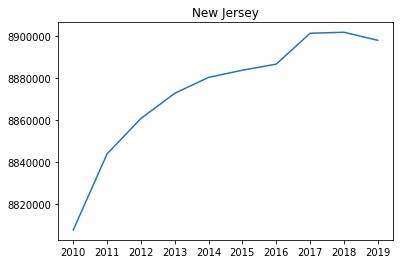

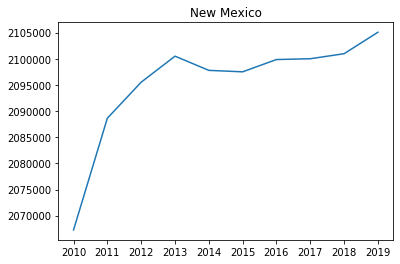

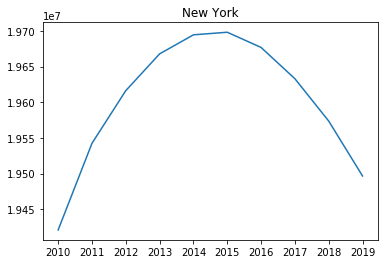

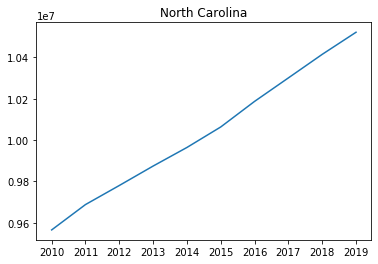

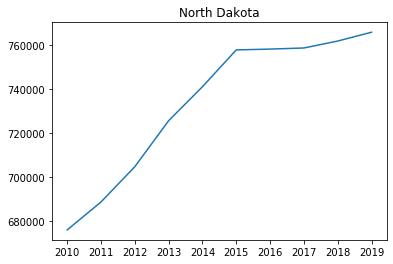

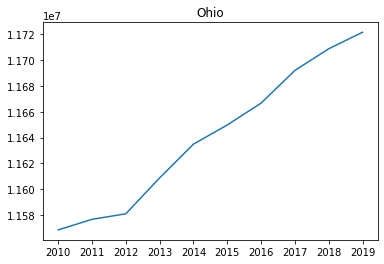

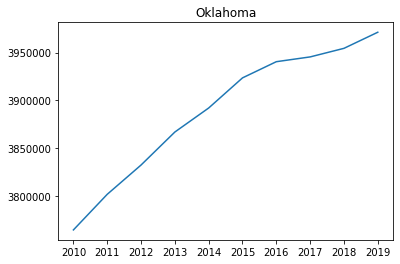

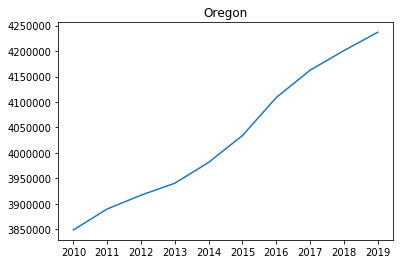

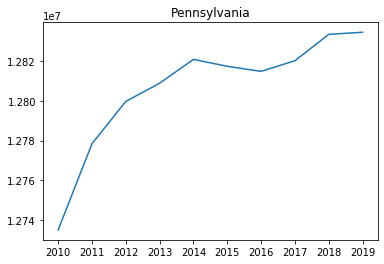

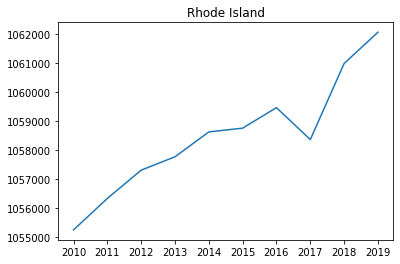

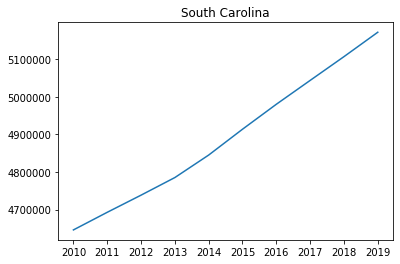

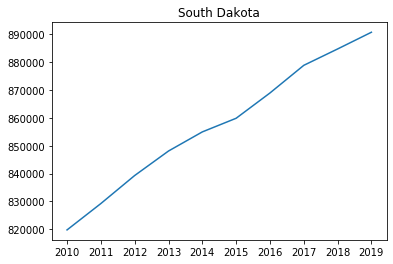

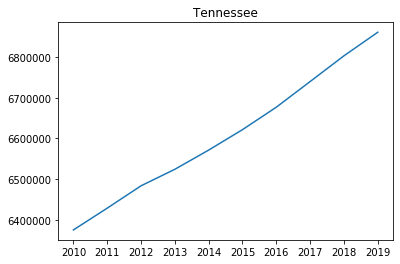

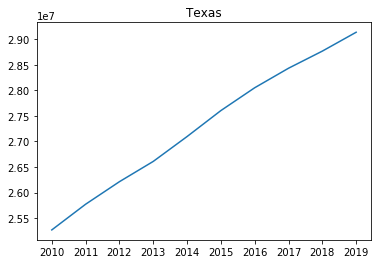

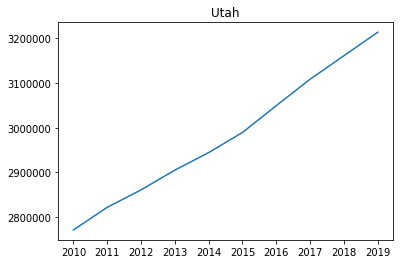

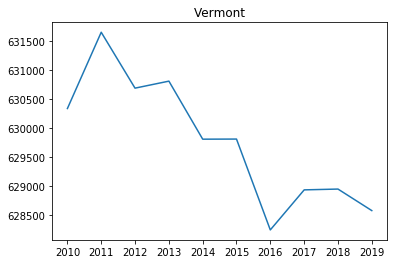

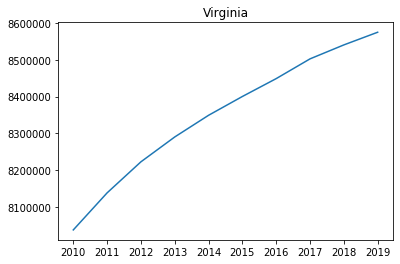

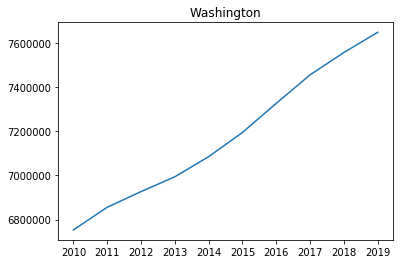

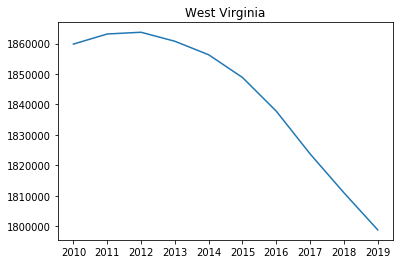

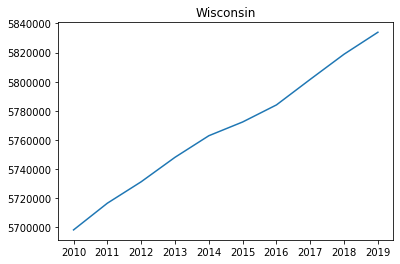

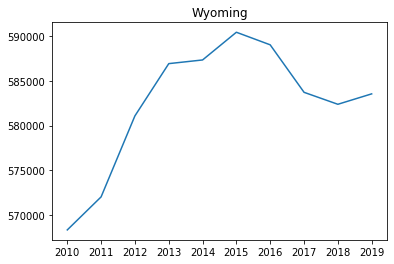

<Figure size 432x288 with 0 Axes>

In [40]:
for state in population_df['state'].unique():
    temp_df = population_df[population_df['state'] == state].copy()
    temp_df['year'] = pd.to_datetime(temp_df['year'], format="%Y")
    temp_df.set_index('year', inplace=True)

    plt.plot(temp_df['pop'] + temp_df['overseas_pop'])
    plt.title(state)
    plt.show()
    plt.clf()

### Test Priority Value and Seat Assignment functions

I also want to look at apportionment of electoral votes (based off house seat apportionment, save DC who has electoral votes but no house seats). While I did pull in data from the Census Bureau for their apportionment, I need to make my own calculations for 2020 apportionment predictions, so this is a good opportunity to test my algorithms against the Census's process.

While the reapportionment will not be enacted until after the 2020 election takes place (reapportionment usually happens in January of the 3rd year after the census takes place), it will be extremely important for the 2024 election.

In [77]:
# init dictionary for states and their populations, house seats, and priority value
state_dict = {}

# query database and put data to manipulate in dictionary
c.execute('SELECT state, (pop + overseas_pop) as total_pop \
           FROM population \
           WHERE year = 2010 AND state NOT IN ("District of Columbia", "Puerto Rico") \
           ORDER BY state')
for state in c.fetchall():
    state_dict.update({state[0]: {'Population': state[1],
                                  'House_seats': 1,
                                  'Priority_value': priority_value(state[1], 2)}})
    
display(state_dict)
display(len(state_dict.keys()))

{'Alabama': {'Population': 4802982,
  'House_seats': 1,
  'Priority_value': 3396221},
 'Alaska': {'Population': 721523, 'House_seats': 1, 'Priority_value': 510194},
 'Arizona': {'Population': 6412700,
  'House_seats': 1,
  'Priority_value': 4534464},
 'Arkansas': {'Population': 2926229,
  'House_seats': 1,
  'Priority_value': 2069156},
 'California': {'Population': 37341989,
  'House_seats': 1,
  'Priority_value': 26404774},
 'Colorado': {'Population': 5044930,
  'House_seats': 1,
  'Priority_value': 3567304},
 'Connecticut': {'Population': 3581628,
  'House_seats': 1,
  'Priority_value': 2532593},
 'Delaware': {'Population': 900877,
  'House_seats': 1,
  'Priority_value': 637016},
 'Florida': {'Population': 18900773,
  'House_seats': 1,
  'Priority_value': 13364865},
 'Georgia': {'Population': 9727566,
  'House_seats': 1,
  'Priority_value': 6878428},
 'Hawaii': {'Population': 1366862, 'House_seats': 1, 'Priority_value': 966517},
 'Idaho': {'Population': 1573499, 'House_seats': 1, 'Pr

50

In [78]:
# creates a dictionary with house seats properly distributed
apportioned_dict = distribute_house_seats(state_dict)

In [119]:
# reads census apportionment of house seats into pandas dataframe and cleans
census_apportionment = pd.read_excel('ApportionmentPopulation2010.xls', skiprows=10, usecols=[0,3])[:50]
census_apportionment.columns = ['State','House_seats']
census_apportionment['House_seats'] = census_apportionment.House_seats.astype('int64')

#set the index to the state to make the following code block easier to parse through
census_apportionment.set_index('State', inplace=True)

display(census_apportionment.head())
display(census_apportionment.info())

,House_seats
State,
Alabama,7
Alaska,1
Arizona,9
Arkansas,4
California,53


<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Alabama to Wyoming
Data columns (total 1 columns):
House_seats    50 non-null int64
dtypes: int64(1)
memory usage: 800.0+ bytes


None

In [80]:
# prints out the state, the calculated house seats through my code, the actual assigned seats according
# to the census bureau, and if they match (to check that my math matches theirs)

print('State', '\t\t', 'Calc', '\t', 'Actual', 'Match')
print()
for state in apportioned_dict.keys():
    if len(state) <= 6:
        print(state, '\t\t', apportioned_dict[state]['House_seats'], '\t', census_apportionment.loc[state][0], 
              '\t', apportioned_dict[state]['House_seats'] == census_apportionment.loc[state][0])
    else:
        print(state, '\t', apportioned_dict[state]['House_seats'], '\t', census_apportionment.loc[state][0], 
              '\t', apportioned_dict[state]['House_seats'] == census_apportionment.loc[state][0]) 

State 		 Calc 	 Actual Match

Alabama 	 7 	 7 	 True
Alaska 		 1 	 1 	 True
Arizona 	 9 	 9 	 True
Arkansas 	 4 	 4 	 True
California 	 53 	 53 	 True
Colorado 	 7 	 7 	 True
Connecticut 	 5 	 5 	 True
Delaware 	 1 	 1 	 True
Florida 	 27 	 27 	 True
Georgia 	 14 	 14 	 True
Hawaii 		 2 	 2 	 True
Idaho 		 2 	 2 	 True
Illinois 	 18 	 18 	 True
Indiana 	 9 	 9 	 True
Iowa 		 4 	 4 	 True
Kansas 		 4 	 4 	 True
Kentucky 	 6 	 6 	 True
Louisiana 	 6 	 6 	 True
Maine 		 2 	 2 	 True
Maryland 	 8 	 8 	 True
Massachusetts 	 9 	 9 	 True
Michigan 	 14 	 14 	 True
Minnesota 	 8 	 8 	 True
Mississippi 	 4 	 4 	 True
Missouri 	 8 	 8 	 True
Montana 	 1 	 1 	 True
Nebraska 	 3 	 3 	 True
Nevada 		 4 	 4 	 True
New Hampshire 	 2 	 2 	 True
New Jersey 	 12 	 12 	 True
New Mexico 	 3 	 3 	 True
New York 	 27 	 27 	 True
North Carolina 	 13 	 13 	 True
North Dakota 	 1 	 1 	 True
Ohio 		 16 	 16 	 True
Oklahoma 	 5 	 5 	 True
Oregon 		 5 	 5 	 True
Pennsylvania 	 18 	 18 	 True
Rhode Island 	 2 	 2 

### The apportionment algorithm works!!

In [125]:
electoral_votes = census_apportionment.reset_index()
electoral_votes = electoral_votes.append(pd.Series({'State':'District of Columbia', 
                                                    'House_seats': 1}), ignore_index=True)
electoral_votes['Electoral_votes'] = electoral_votes.House_seats.apply(lambda x: x+2)
electoral_votes.drop('House_seats', axis=1, inplace=True)

electoral_votes = electoral_votes.sort_values('State').reset_index(drop=True)

display(electoral_votes.head())
display(electoral_votes.tail())
display(electoral_votes.info())

electoral_votes.to_csv('cleaned_electoral_votes_2010.csv', index=False)

,State,Electoral_votes
0,Alabama,9
1,Alaska,3
2,Arizona,11
3,Arkansas,6
4,California,55
5,Colorado,9
6,Connecticut,7
7,Delaware,3
8,District of Columbia,3
9,Florida,29


,State,Electoral_votes
46,Virginia,13
47,Washington,12
48,West Virginia,5
49,Wisconsin,10
50,Wyoming,3


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 2 columns):
State              51 non-null object
Electoral_votes    51 non-null int64
dtypes: int64(1), object(1)
memory usage: 944.0+ bytes


None

In [126]:
c.close()
conn.close()

ProgrammingError: Cannot operate on a closed database.